In [1]:
import pandas as pd
import numpy as np

In [17]:
df = pd.read_csv("poses_unity.csv")  # Replace with your actual file path
print(df.shape)
# Get the column and compute differences
n= 1


for col_name  in ["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"]:
    # print(col_name)
    d = df[col_name].values
    d_u = np.unique(d)
    print(col_name, len(d_u), d_u)
    # diffs = np.diff(x)

    diffs = np.diff(d_u)
    if np.all(diffs ==diffs[0]) == True:
        # print(diffs)
        pass


    # n = n *len(np.unique(d))





(7043, 7)
pos_x 3 [-0.1  0.   0.1]
pos_y 3 [-0.15  0.    0.15]
pos_z 3 [-0.01  0.    0.01]
rot_x 5 [-15.   -7.5   0.    7.5  15. ]
rot_y 11 [ 0  8 16 24 32 40 48 56 64 72 80]
rot_z 5 [-15.   -7.5   0.    7.5  15. ]


In [18]:

rot_x_get = np.unique(df["rot_x"].values)[::2]
rot_y_get = np.unique(df["rot_y"].values)[::2]
rot_z_get = np.unique(df["rot_z"].values)[::2]

print(len(rot_x_get), rot_x_get)
print(len(rot_y_get), rot_y_get)
print(len(rot_z_get), rot_z_get)


# for get in [rot_x_get, rot_y_get, rot_z_get]
df2 = df[(df["rot_x"].isin(rot_x_get)) & (df["rot_y"].isin(rot_y_get)) & (df["rot_z"].isin(rot_z_get))]
df2.shape


3 [-15.   0.  15.]
6 [ 0 16 32 48 64 80]
3 [-15.   0.  15.]


(1319, 7)

In [ ]:
df.head(10)

In [5]:
np.unique(x)

array([-0.1,  0. ,  0.1])

In [9]:
n

15525

In [20]:
diffs = np.array([2,1,1])
if np.all(diffs ==diffs[0]) == True:
    print(diffs)    

In [2]:
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.pyplot as plt
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers import DDPMPipeline
import math
import os
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch
from diffusers import UNet2DModel
from torchvision import transforms
import random 

import numpy as np
from PIL import Image
import torch.nn.functional as F
from diffusers import DDPMScheduler
from torch.utils.data import DataLoader
import pandas as pd
from torch.utils.data import Dataset
from torch import nn

import torchvision.transforms as T
from diffusers import UNet2DConditionModel
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid


class ImageVectorDataset3DUSG(Dataset):
    def __init__(self, image_dir, label_csv, image_size=64):
        self.df = pd.read_csv(label_csv)
        self.image_dir = image_dir

        # Filter rows based on step from image filenames like image_0.png to image_359.png
        # self.df["index"] = self.df["filename"].str.extract(r"_(\d+)\.")[0].astype(int)
        # self.df = self.df[self.df["index"] % step == 0].reset_index(drop=True)

        # print(self.df)

        self.image_names = os.listdir(self.image_dir)
        print(len(self.image_names))

        self.df = self.df[self.df['filename'].isin(self.image_names)]
        print(self.df.shape)


        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])
        ])



        print(self.df.shape)
        self.t = 1
        self.lastimg = None

        for col_name  in ["pos_x", "pos_y", "pos_z", "rot_x", "rot_y", "rot_z"]:
            # print(col_name)
            d = self.df[col_name].values
            d_u = np.unique(d)
            print(col_name, len(d_u), d_u)
            # diffs = np.diff(x)

            diffs = np.diff(d_u)
            print(diffs)
            # if np.all(diffs ==diffs[0]) == True:
            #     # print(diffs)
            #     pass



    def preprocess(self):
        rot_x_get = np.unique(self.df["rot_x"].values)
        rot_y_get = np.unique(self.df["rot_y"].values)
        rot_z_get = np.unique(self.df["rot_z"].values)

        print(len(rot_x_get), rot_x_get)
        print(len(rot_y_get), rot_y_get)
        print(len(rot_z_get), rot_z_get)


        # for get in [rot_x_get, rot_y_get, rot_z_get]
        self.df = self.df[(self.df["rot_x"].isin(rot_x_get)) & (self.df["rot_y"].isin(rot_y_get)) & (self.df["rot_z"].isin(rot_z_get))]
        print("After preprocess ", self.df.shape)



    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image_path = os.path.join(self.image_dir, row['filename'])

        try:
            image = Image.open(image_path).convert("L")
            
            image = self.transform(image)
            self.lastimg = image

            
        except Exception as e:
            self.t+=1

            image = self.lastimg
            print(image_path)
            
        vector = torch.tensor([row['pos_x'], row['pos_y'], row['pos_z'], row['rot_x'], row['rot_y'], row['rot_z']], dtype=torch.float32)
        return image, vector #image_path.split("/")[-1]



/home/MichalMo/anaconda3/envs/SD1/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
dataset = ImageVectorDataset3DUSG("dataset_Vol3_4/images", "dataset_Vol3_4/poses_unity.csv", image_size=128)
# dataset.preprocess()

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
len(train_dataloader)

18628
(18628, 7)
(18628, 7)
pos_x 3 [-0.01  0.    0.01]
[0.01 0.01]
pos_y 7 [-1.50000000e-01 -1.00000000e-01 -5.00000000e-02  2.77555756e-17
  5.00000000e-02  1.00000000e-01  1.50000000e-01]
[0.05 0.05 0.05 0.05 0.05 0.05]
pos_z 3 [-0.01  0.    0.01]
[0.01 0.01]
rot_x 11 [-15. -12.  -9.  -6.  -3.   0.   3.   6.   9.  12.  15.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
rot_y 11 [-15. -12.  -9.  -6.  -3.   0.   3.   6.   9.  12.  15.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
rot_z 11 [-15. -12.  -9.  -6.  -3.   0.   3.   6.   9.  12.  15.]
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


2329

In [12]:
p = "dataset_Vol3_4/images"
len(os.listdir(p))

18628

In [13]:
for step, (clean_images, cond_vectors) in enumerate(train_dataloader):
    pass
    # print(step)

    # if step == 1:
    #     break

    # for j in range(clean_images.shape[0]):
    #     print(clean_images.shape, cond_vectors[j])

    #     plt.imshow(clean_images[j].permute(1,2,0))
    #     plt.show()




In [33]:
dataset.t

2

In [3]:
from dataclasses import dataclass
from datasets import load_dataset
import matplotlib.pyplot as plt
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers import DDPMPipeline
import math
import os
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch
from diffusers import UNet2DModel
from torchvision import transforms
import random 
import numpy as np


from PIL import Image
import torch.nn.functional as F
from diffusers import DDPMScheduler
from torch.utils.data import DataLoader
import pandas as pd
from torch.utils.data import Dataset
from torch import nn

import torchvision.transforms as T
from diffusers import UNet2DConditionModel
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

In [5]:
from dataclasses import dataclass
import dataclasses


@dataclass
class TrainingConfig:

    image_size: int = 128  # the generated image resolution
    train_batch_size: int  = 32
    eval_batch_size: int  = 16  # how many images to sample during evaluation

    num_epochs: int = 7000
    save_image_epochs: int  = 150
    save_model_epochs: int  = 150

    
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_warmup_steps: int =1

    mixed_precision:str = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir:str = "t"  # the model name locally and on the HF Hub


import json
config = TrainingConfig()
print(config.image_size)

with open("training_config.json", "w") as f:
    json.dump(dataclasses.asdict(config), f, indent=4)

128


In [6]:





class CustomConditionedUNet(nn.Module):
    def __init__(self, base_unet: UNet2DConditionModel, cond_dim=6, embedding_dim=128):
        super().__init__()
        self.unet = base_unet
        self.cond_embed = nn.Sequential(
            nn.Linear(cond_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

        self.config = self.unet.config



    def forward(self, sample, timestep, cond_vector=None):
        # [B, 128] -> [B, 1, 128] (cross-attention format)
        cond_emb = self.cond_embed(cond_vector).unsqueeze(1)

        return self.unet(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=cond_emb
        )


base_unet = UNet2DConditionModel(
    sample_size=config.image_size, in_channels=1, out_channels=1, layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # now 4 blocks = 4 values
    down_block_types=('DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D',  'AttnDownBlock2D'),

    up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D',  'UpBlock2D', 'UpBlock2D'),
    cross_attention_dim=128
)

model = CustomConditionedUNet(base_unet)

In [5]:
x = "poses_unity_Vol3.csv"

df = pd.read_csv(x)
df.head()

,id,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z
0,plane1.png,-0.1,-0.15,-0.01,-15.0,0,-15.0
1,plane2.png,-0.1,-0.15,0.00,-15.0,0,-15.0
2,plane3.png,-0.1,-0.15,0.01,-15.0,0,-15.0
3,plane4.png,0.0,-0.15,-0.01,-15.0,0,-15.0
4,plane5.png,0.0,-0.15,0.00,-15.0,0,-15.0


In [6]:
df.shape

(15525, 7)

In [9]:
print(df['pos_x'].unique())
print(df['pos_y'].unique())
print(df['pos_z'].unique())
print(df['rot_x'].unique())
print(df['rot_y'].unique())
print(df['rot_z'].unique())

[-0.1  0.   0.1]
[-0.15  0.    0.15]
[-0.01  0.    0.01]
[-15.   -7.5   0.    7.5  15. ]
[  0   8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136
 144 152 160 168 176]
[-15.   -7.5   0.    7.5  15. ]


In [5]:
from diffusers import UNet2DConditionModel


model = UNet2DConditionModel(
    sample_size=64, in_channels=1, out_channels=1, layers_per_block=2,
    block_out_channels=(64, 128, 256, 256, 512),  # now 4 blocks = 4 values
    down_block_types=('DownBlock2D', 'DownBlock2D', 'DownBlock2D', 'AttnDownBlock2D',  'AttnDownBlock2D'),

    up_block_types=('AttnUpBlock2D', 'AttnUpBlock2D','UpBlock2D', 'UpBlock2D', 'UpBlock2D'),
    cross_attention_dim=128
)

In [6]:
num_epochs = 1000
    
lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=(583 * num_epochs),
    )

NameError: name 'optimizer' is not defined

In [55]:
import torch
import math

from diffusers.optimization import get_cosine_schedule_with_warmup
from torch.optim.lr_scheduler import LambdaLR

def get_custom_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps,
    num_training_steps,
    min_lr_ratio=0.1,  # Final LR will be min_lr_ratio * base LR
    last_epoch=-1,
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        cosine_decay = 0.5 * (1.0 + math.cos(math.pi * progress))
        scaled_decay = min_lr_ratio + (1.0 - min_lr_ratio) * cosine_decay
        return max(scaled_decay, min_lr_ratio)

    return LambdaLR(optimizer, lr_lambda, last_epoch=last_epoch)



optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)




In [56]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 1000
steps_per_epoch = 583
total_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.03 * total_steps)  # 3% warmup
base_lr = 1e-4
final_lr_ratio = 0.0  # 10% of peak

scheduler = get_custom_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    min_lr_ratio=final_lr_ratio)  # e.g., ends at 10% of max LR

# Create dummy optimizer
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)


# Override last learning rate manually (final LR != 0)
original_lrs = []
for step in range(total_steps):
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    # Apply minimum LR cap after cosine decay
    min_lr = base_lr * final_lr_ratio
    current_lr = max(current_lr, min_lr)
    original_lrs.append(current_lr)

print(original_lrs[-5:])

# # Plotting
# plt.figure(figsize=(10, 5))
# plt.plot(original_lrs)
# plt.title("Cosine LR Schedule with Warmup (Final LR not zero)")
# plt.xlabel("Training Step")
# plt.ylabel("Learning Rate")
# plt.grid(True)
# plt.show()

[1.2344658628649087e-14, 6.943873254172673e-15, 3.0861646571622717e-15, 7.715439398481295e-16, 0.0]


In [115]:

# Create dummy optimizer
model = torch.nn.Linear(10, 1)


num_epochs = 400
steps_per_epoch = 583
total_steps = num_epochs * steps_per_epoch
warmup_steps = 0  # 3% warmup
base_lr = 0.25 * 1e-4
final_lr_ratio = 0.25  # 10% of peak


optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)

scheduler = get_custom_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
    min_lr_ratio=final_lr_ratio)  # e.g., ends at 10% of max LR


# Override last learning rate manually (final LR != 0)
original_lrs2 = []
for step in range(total_steps):
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    # Apply minimum LR cap after cosine decay
    min_lr = base_lr * final_lr_ratio
    current_lr = max(current_lr, min_lr)
    original_lrs2.append(current_lr)

In [116]:
# original_lrs2.append(current_lr)
print(original_lrs2[:5])
print(original_lrs2[-5:])

[2.499999999914929e-05, 2.499999999659714e-05, 2.499999999234357e-05, 2.4999999986388568e-05, 2.4999999978732136e-05]
[6.250000013611434e-06, 6.250000007656431e-06, 6.250000003402859e-06, 6.2500000008507145e-06, 6.25e-06]


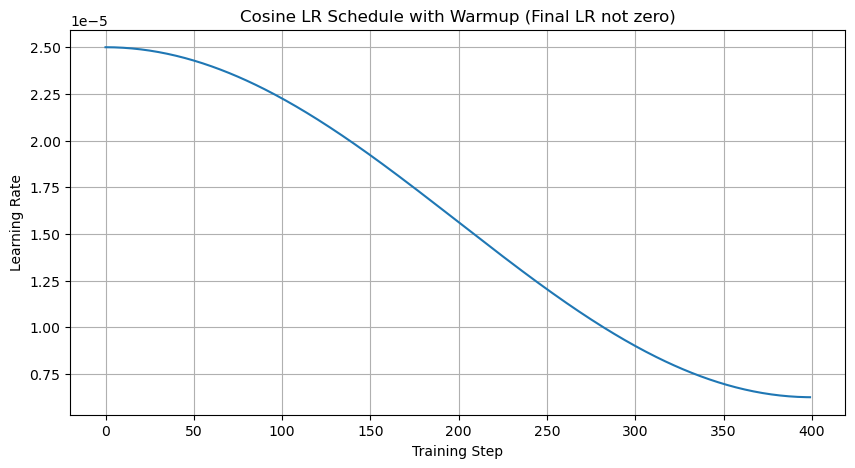

In [117]:
# Plotting
plt.figure(figsize=(10, 5))
# plt.plot(original_lrs)
plt.plot(original_lrs2[::steps_per_epoch])

plt.title("Cosine LR Schedule with Warmup (Final LR not zero)")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

In [118]:
original_lrs2

[2.499999999914929e-05,
 2.499999999659714e-05,
 2.499999999234357e-05,
 2.4999999986388568e-05,
 2.4999999978732136e-05,
 2.499999996937427e-05,
 2.4999999958314982e-05,
 2.499999994555426e-05,
 2.499999993109211e-05,
 2.499999991492853e-05,
 2.4999999897063523e-05,
 2.4999999877497085e-05,
 2.4999999856229216e-05,
 2.4999999833259922e-05,
 2.4999999808589197e-05,
 2.499999978221704e-05,
 2.4999999754143454e-05,
 2.4999999724368443e-05,
 2.4999999692892e-05,
 2.4999999659714127e-05,
 2.4999999624834824e-05,
 2.499999958825409e-05,
 2.499999954997193e-05,
 2.499999950998834e-05,
 2.4999999468303322e-05,
 2.4999999424916875e-05,
 2.4999999379828996e-05,
 2.499999933303969e-05,
 2.4999999284548953e-05,
 2.499999923435679e-05,
 2.499999918246319e-05,
 2.4999999128868167e-05,
 2.4999999073571715e-05,
 2.4999999016573834e-05,
 2.4999998957874522e-05,
 2.4999998897473782e-05,
 2.499999883537161e-05,
 2.4999998771568013e-05,
 2.4999998706062984e-05,
 2.4999998638856524e-05,
 2.499999856994863

results_3d_usvol3_ds4_2 min loss:  0.0029227843459801
-7.116905792198802e-06
-9.301495971303477e-06


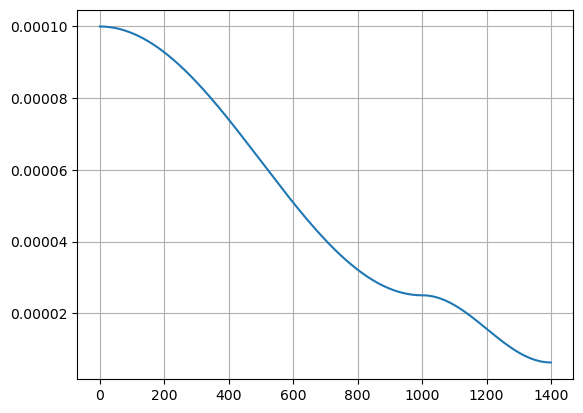

In [119]:
# Add to previus training

results_list = ["results_3d_usvol3_ds4_2/training_log.csv"] # "results_3d_usvol3_ds4_2/training_log.csv"

for res in results_list:
    # print(res.split("/")[0])

    df = pd.read_csv(res)
    # print(df)
    name = res.split("/")[0]

    print(name, "min loss: ", df['Loss'].min())

    x = df["Epoch"].values.tolist()
    y = df["Learning Rate"].values.tolist()

    x.extend([i for i in range(1000,1400)])
    y.extend(original_lrs2[::steps_per_epoch])

    # print(df["Epoch"].values.tolist())
    # print(x)
    # print(len(y))
    # print([i for i in range(1000,1200)])

    print(y[1000] - y[800])
    print(y[1200-1] - y[1000])

    plt.plot(x,y)


    plt.grid()
    # plt.legend()
    # plt.title(name)
plt.show()

In [45]:
from torch.optim.lr_scheduler import _LRScheduler
import math

class SmoothCosineWithWarmupScheduler(_LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps,
        num_training_steps,
        warmup_smooth_power=2.0,
        final_lr_ratio=0.1,
        last_epoch=-1,
    ):
        self.num_warmup_steps = num_warmup_steps
        self.num_training_steps = num_training_steps
        self.warmup_smooth_power = warmup_smooth_power
        self.final_lr_ratio = final_lr_ratio
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch
        base_lrs = [group['initial_lr'] for group in self.optimizer.param_groups]
        final_lrs = [lr * self.final_lr_ratio for lr in base_lrs]

        lrs = []
        for base_lr, final_lr in zip(base_lrs, final_lrs):
            if step < self.num_warmup_steps:
                warmup_pct = step / max(1, self.num_warmup_steps)
                lr = base_lr * warmup_pct ** self.warmup_smooth_power
            else:
                decay_step = step - self.num_warmup_steps
                decay_total = max(1, self.num_training_steps - self.num_warmup_steps)
                cosine_decay = 0.5 * (1 + math.cos(math.pi * decay_step / decay_total))
                lr = final_lr + (base_lr - final_lr) * cosine_decay
            lrs.append(lr)
        return lrs


[1.0000000011110193e-05, 1.0000000006249486e-05, 1.0000000002777549e-05, 1.000000000069439e-05, 1e-05]


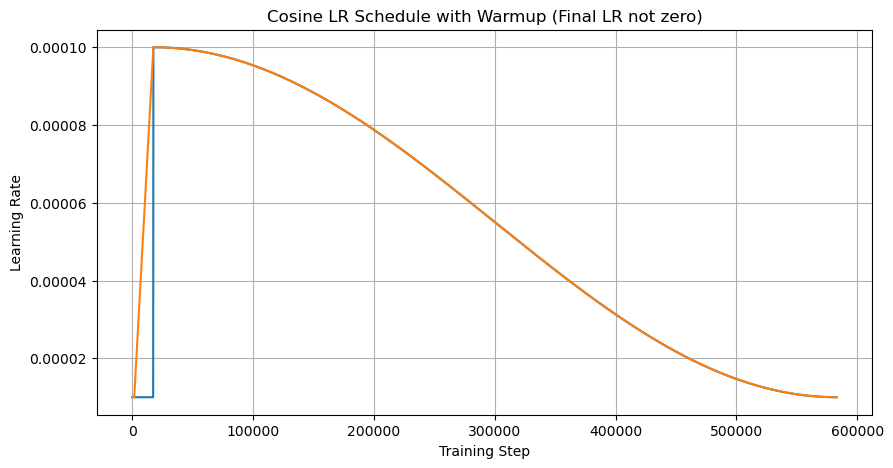

In [55]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 1000
steps_per_epoch = 583
total_steps = num_epochs * steps_per_epoch
warmup_steps = int(0.03 * total_steps)  # 3% warmup
base_lr = 1e-4
final_lr_ratio = 0.1  # 10% of peak

lr_scheduler_sm = SmoothCosineWithWarmupScheduler(
    optimizer=optimizer,
    num_warmup_steps=int(0.03 * total_steps),   # 10% warmup
    num_training_steps=total_steps,
    warmup_smooth_power=500.0,                   # Smooth start
    final_lr_ratio=final_lr_ratio                        # Ends at 10% of base_lr
)


# Create dummy optimizer
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)


# Override last learning rate manually (final LR != 0)
original_lrs3 = []
for step in range(total_steps):
    lr_scheduler_sm.step()
    current_lr = lr_scheduler_sm.get_last_lr()[0]
    # Apply minimum LR cap after cosine decay
    min_lr = base_lr * final_lr_ratio
    current_lr = max(current_lr, min_lr)
    original_lrs3.append(current_lr)

print(original_lrs3[-5:])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(original_lrs3)
plt.plot(original_lrs)

plt.title("Cosine LR Schedule with Warmup (Final LR not zero)")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

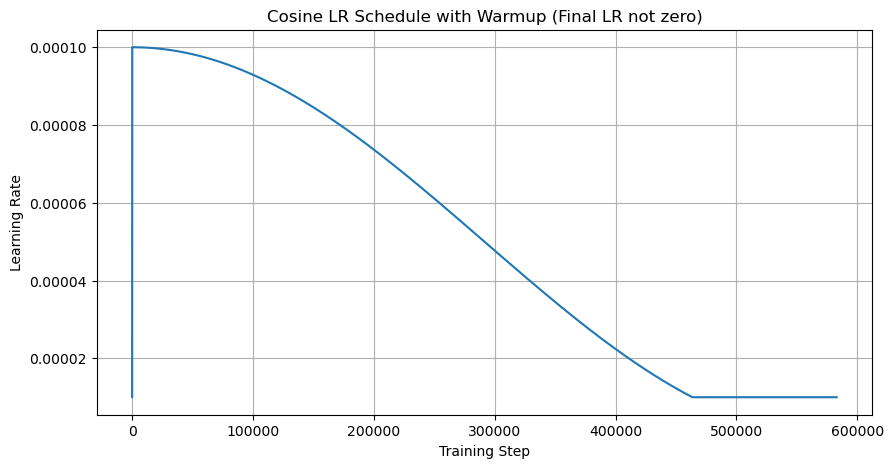

In [15]:
num_epochs = 1000
steps_per_epoch = 583
total_steps = num_epochs * steps_per_epoch
warmup_steps = 50
base_lr = 1e-4

# Create dummy optimizer
model = torch.nn.Linear(10, 1)
optimizer = torch.optim.AdamW(model.parameters(), lr=base_lr)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)


# Override last learning rate manually (final LR != 0)
original_lrs = []
for step in range(total_steps):
    lr_scheduler.step()
    current_lr = lr_scheduler.get_last_lr()[0]
    # Apply minimum LR cap after cosine decay
    min_lr = base_lr * final_lr_ratio
    current_lr = max(current_lr, min_lr)
    original_lrs.append(current_lr)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(original_lrs)
plt.title("Cosine LR Schedule with Warmup (Final LR not zero)")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()